In [1]:
# https://pcb-tools.readthedocs.io/en/latest/documentation/rs274x.html#functions
# may check this for lines : https://raw.githubusercontent.com/kirberich/gerber_to_scad/master/gerber_to_scad.py
# but first try with cv2
import gerber
import numpy as np
import io
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from IPython.display import clear_output, Image, display
import PIL.Image
%matplotlib inline

In [2]:
stencil = gerber.read('solderpaste_top3.gbr')
bound_x = stencil.bounds[0][1]
bound_y = stencil.bounds[1][1]
#stencil.primitives

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

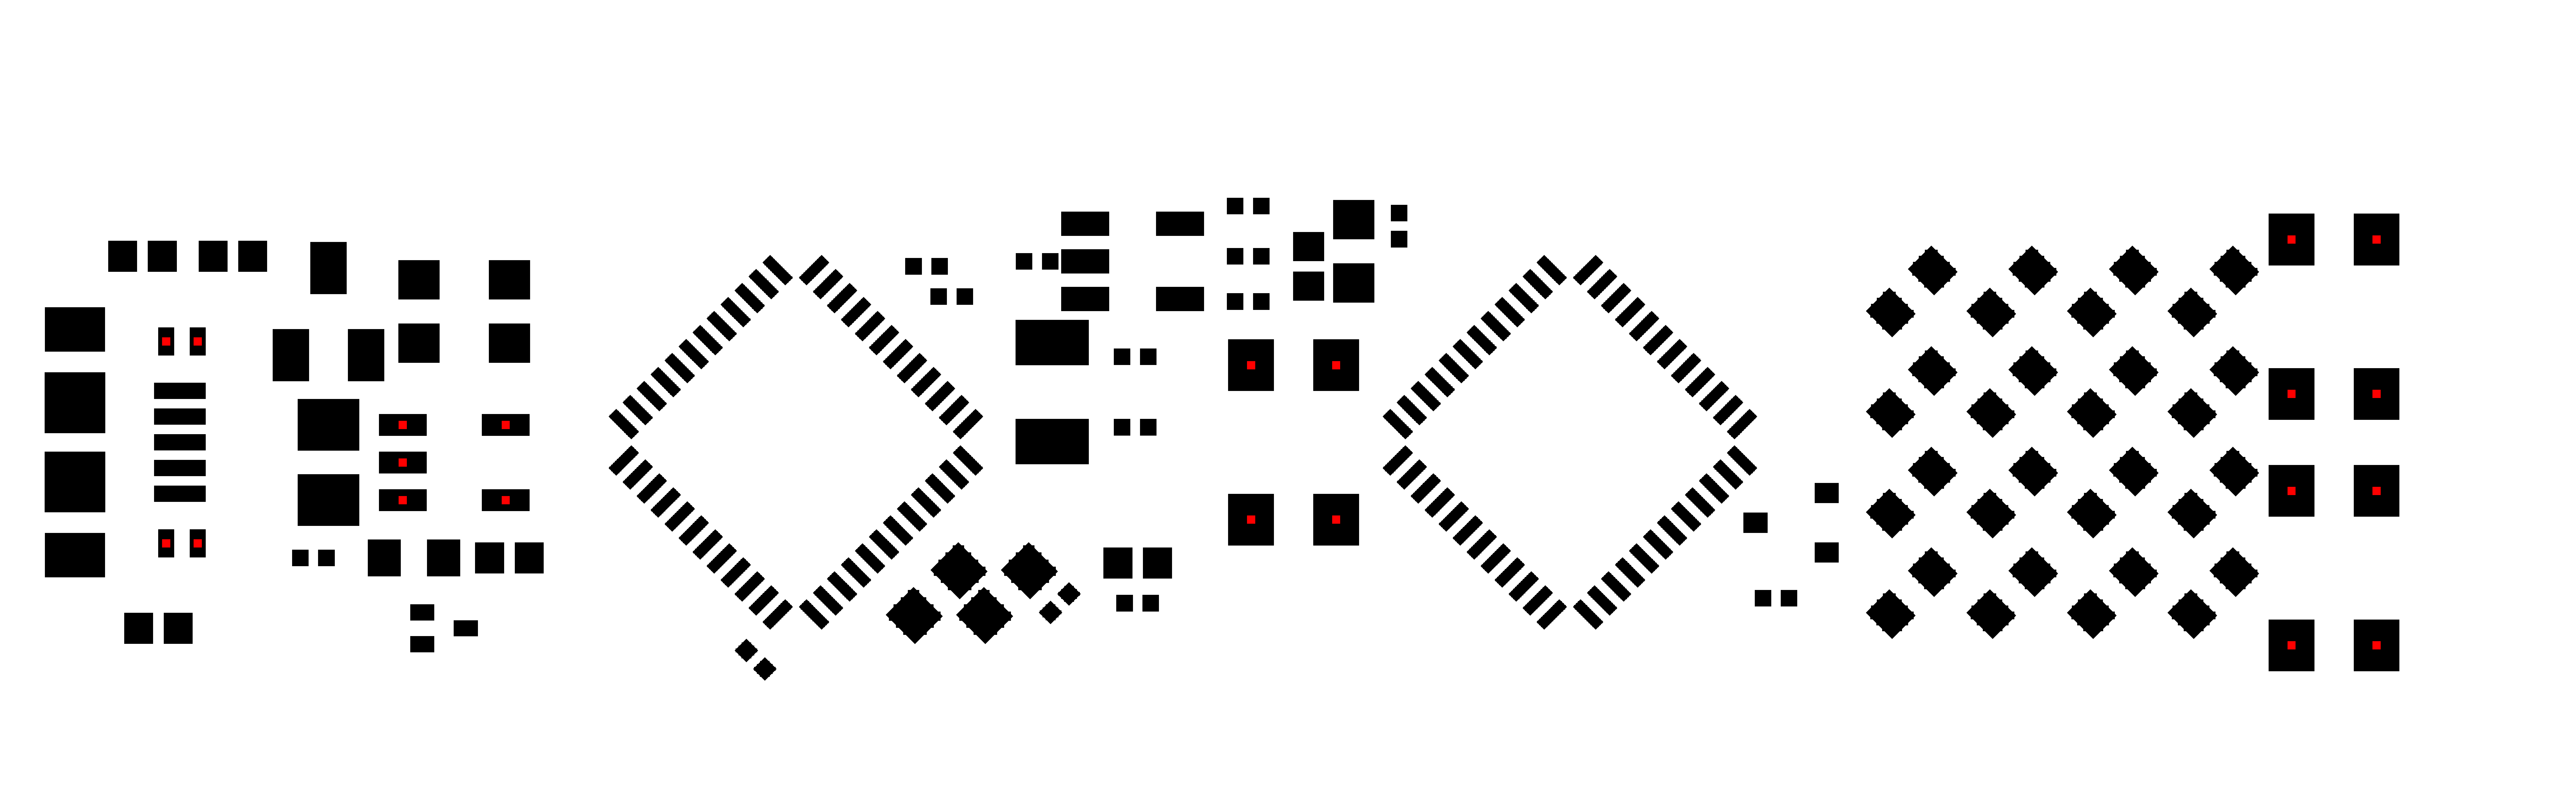

In [3]:
fig2 = plt.figure(figsize=(bound_x*4,bound_y*4))
ax2 = fig2.add_subplot(111, aspect='equal')
ax2.set_xlim(0, bound_x+5)
ax2.set_ylim(0, bound_y+5)

dots = 0
for i in stencil.primitives:
    if isinstance(i,gerber.primitives.Line ): 
        ax2.add_line(Line2D([i._start[0] , i._end[0] ], [i._start[1] , i._end[1]] , color=(0,0,0), linewidth=i.aperture._diameter*200 ))
        # print(i.aperture._diameter)
        # print(i.aperture.__dict__)
        # TODO: here we need convert lines into rectangle!!!!
    elif isinstance(i,gerber.primitives.Region ):
        pass
    elif isinstance(i,gerber.primitives.Rectangle ):
        dots = dots + 1
        x = i._position[0] - i._width * 0.5
        y = i._position[1] - i._height * 0.5
        # draw pad corders
        ax2.add_patch( patches.Rectangle((x  ,y ), i._width,i._height, fill=True,color=(0.0,0.0,0.0) ) ) 
        # add center Dot to pads
        ax2.add_patch( patches.Rectangle((i._position[0]-0.1  ,i._position[1]-0.1 ),0.2,0.2, 
                                         fill=True, color=(1,0,0) ) ) 
        
        if (i._width * i._height) > 2:  # add more dots on big pads
            for xd in np.arange (x + 0.2 , x + i._width -0.4, 0.8):
                for yd in np.arange (y + 0.2 , y + i._height -0.4 , 0.8):
                    ax2.add_patch( patches.Rectangle((xd-0.1  ,yd-0.1 ),0.1,0.1, fill=True, color=(0,0,1) ) ) 
                    dots = dots + 1
                
    else: 
        #print(i)
        #print(i.__dict__)
        pass

plt.axis('off')    
plt.show()

# Convert Image Into cv2 compatible image
io_buf = io.BytesIO()
fig2.savefig(io_buf, format='raw')
io_buf.seek(0)
img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig2.bbox.bounds[3]), int(fig2.bbox.bounds[2]), -1))
io_buf.close()
#print(dots)
#cv2.imshow('stencil',img_arr)
#cv2.waitKey()

In [ ]:
imgOrg   = img_arr.copy()  
img      = cv2.cvtColor(img_arr,cv2.COLOR_BGR2GRAY)
#cv2.imshow('cont',img)
#cv2.waitKey()
width  = img.shape[0]
height = img.shape[1] 
#print(width,height)    
#imageBlank = np.zeros((height, width, 3), np.uint8)
#imageBlank = img
contours, hierarchy  = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    center1 = (x+w//2 -6, y+h//2 -6)
    center2 = (x+w//2 +6, y+h//2 +6)
    # print(cv2.boundingRect(contour))
    cv2.rectangle(imgOrg, center1, center2, (0, 255, 255), 8)
    

#plt.clf()
#plt.rcParams["figure.figsize"] = (bound_x,bound_y)
#plt.figure(figsize = (bound_x, bound_y))
#plt.axis('off')    
#plt.imshow(imgOrg)
#plt.show()

cv2.imshow('cont',imgOrg)
cv2.waitKey()
cv2.destroyAllWindows()